# 7a. Integration of Particle Orbits

As explained in the lecture, the integration of particle paths is on the one hand a non-trivial issue, in that one must be careful when choosing the method of integration, so particles don't lose or gain energy for purely numerical reasons.  On the other hand there does exist a simple and robust method; the kick-drift-kick (KDK) method, which is good enough for most practical purposes, except maybe longterm integration of planetary orbits.

### Overview
The purpose of this exercise is to give you a feeling for how many steps per orbit are needed to obtain a reasonable precision, and what kinds of errors that are avoided by using an energy conserving, "symplectic" (cf. Section 3.6 in the book) method. The next exercise will continue to build on this one, adding drag between the particles and a schematic, rotating proto-planetary disk.

### Setup
This notebook initialises `n` particles in the central potential of a star. _Keplerian_ units of mass = 1 solar mass, length = 1 au, and time = 1 yr are chosen such that GM = $4\pi^2$ for a 1 solar mass star. The particle orbits have radii `rad` with some normal distributed distribution with std dev `dispersion`, and `eccentricity` (0 for circular, 1 for direct infall) with a normal distributed spread `edispersion`. Since normally distributed variables can have arbitrarily large values we limit the radial distribution to the interval `[rmin, rmax]`and the eccentricity is below `emax`.

### The Kepler problem
The Kepler problem is a simplified two-body problem, where one of the bodies is a mass-less test particle. The motion is characterised by the two constants of motion. The specific (per mass) energy:

\begin{equation}
E = {1 \over 2} v^2 - {GM \over r}
\end{equation}
and the specific (per mass) angular momentum is
\begin{equation}
L = r \times v
\end{equation}
The acceleration of the test particle is given from Newton's law of gravitation

\begin{equation}
\mathbf{a} = - \frac{GM}{r^2} \frac{\mathbf{r}}{r}
\end{equation}
For the special case of circular motion we have
\begin{equation}
v_\textrm{circle} = v_\textrm{Kepler} = \sqrt{\frac{GM}{r}}
\end{equation}
and the specific energy is $E_\textrm{circle} = - {1 \over 2} {GM \over r}$.

In the general case the orbit is an ellipse. The eccentricity of the ellipse can be caluculated from the specific energy and angular momentum as
\begin{equation}
e = \sqrt{1 + \frac{2 E L^2}{(GM)^2}}
\end{equation}
the orbit period $P$ and the semi-major axis $a$ are related to the specific energy as

\begin{align}
E  & = - {1 \over 2} {GM \over a} \\
P^2 & = \frac{4\pi^2}{GM} a^3
\end{align}

If the specific energy is positive, the particle is unbound.

These few key equations a enough to setup a simple Kepler problem with a given eccentricity and radius as done below.

### Preparations:
1. Review what the issues are, by reading Chapter 3 and/or the slide deck. Apart from secular (slow and systematic) changes in total energy, there are also other types of errors.  Paths that should be exactly elliptic can have nutation, for example, where the aphelion / perihelion positions rotate a small amount for each orbit. Such a path is typically also associated with a variation of total energy along the path so that, even though energy is conserved over full orbits, it is not conserved exactly during one orbit. Examples of that are in the slides, and you will also create your own below.
2. Review the setup below. The notebook contains a `Particles` class with basic particle data and related routines for computing radius, speed, energy, and orbital time.
3. The other class is called `Integration`. It contains a Kick-Drift-Kick integrator and a classical 3rd order Runge-Kutta (RK3) integrator. The KDK integrator has the optional `reflexive` option setting the timestep based on both the current and the future value of the timestep, to make the integration routine symmetric in time. It also has a simple Courant condition that is based on taking `norbit` steps per orbital time.
4. _Take your time_ to review the comments in the `__init__` procedure for each `class`. If you do not understand what the purpose of an option is, please ask.
5. Below the two class definitions is a small example of how to use the setup. With a low number of particles, the time, timestep (dt), position, and total energy of each particle is stored as a function of time, and a few statistics and orbital plots are made. This will help you understand the behaviour of the integrator with different sets of options.

In [6]:
import numpy as np                      # Import numpy and matplotlib.pyplot
import matplotlib.pyplot as plt
import time as tm                       # Import time module for timing measurement
np.set_printoptions(linewidth=120)      # Expand the nr of columns used for printing
np.seterr(invalid='raise');             # Fail the code if any exception is raised 

In [7]:
class Particles():
    def __init__(self, n=50, rad=1., rmin=0.4, rmax=4., dispersion=0.1, \
                 eccentricity=0., edispersion=0.1, emax=0.95, starmass=1., seed=1234):
        self.n = n                          # number of particles
        self.rad = rad                      # radius [in AU] at which they are inserted
        self.rmin = rmin                    # minimum and maximum initial radius
        self.rmax = rmax
        self.dispersion = dispersion        # dispersion [in AU] around radius
        self.eccentricity = eccentricity    # eccentricity of orbits
        self.edispersion = edispersion      # dispersion in eccentricity
        self.emax = emax                    # maximum eccentricity
        self.starmass = starmass            # stellar mass [solar masses]

        # Assume units where [M] = solar mass, [l]=AU, [t]=year.
        # Then the (unit-less) Kepler's law hold true and GM = 2 pi for Sun.
        self.GM = (2. * np.pi)**2 * self.starmass
        
        # Setup particles
        self.r = np.zeros((3,n))            # position
        self.v = np.zeros((3,n))            # momentum
        self.initialize(seed)
        
    def initialize(self,seed):
        """ Initialize random particles uniformly in angle with a dispersion in radius and eccentricity
        """
        np.random.seed(seed)
        self.rm = self.rad + np.random.randn(self.n)*self.dispersion # dispersion is normal distributed
        self.rm = np.clip(self.rm,self.rmin,self.rmax)               # bracket radius inside rmin and rmax
        angle = 2.0*np.pi*np.random.random(self.n)
        self.r[0] = self.rm*np.cos(angle)
        self.r[1] = self.rm*np.sin(angle)

        self.vm = np.sqrt(self.GM/self.rm) # Kepler speed
        self.e = self.eccentricity + np.random.randn(self.n)*self.edispersion # dispersion in eccentricity
        self.e = np.clip(self.e,-self.emax,self.emax)    # limit eccentricity to max "emax"
        alpha = np.sqrt(1. - self.e**2)                  # the velocity correction at aphelion needed to get the eccentricity
        self.v[0] = -self.vm*np.sin(angle)*alpha
        self.v[1] = +self.vm*np.cos(angle)*alpha
    
    def radius(self):
        """ Compute the scalar radii from the vector positions """
        self.rm = np.sqrt(np.sum(self.r**2,0))        

    def speed(self):
        """ Compute the scalar speeds from the vector velocity components """
        self.vm = np.sqrt(np.sum(self.v**2,0))
        
    def energy(self):
        """ Compute reduced energy for particles """
        self.radius()
        self.speed()
        self.E = 0.5*self.vm**2 - self.GM / self.rm
        
    def Porbit(self):
        """ compute orbit time for particles """
        self.energy()
        a = - 0.5 * self.GM / self.E                          # semi-major axis
        a[np.where(a < 0.)] = a.max()                         # let a be largest possible for negative a
        return 2. * np.pi * a * np.sqrt(a) / np.sqrt(self.GM) # Period of orbit

In [8]:
class Integration():
    def __init__(self, p, Integrator='kdk', Courant='acceleration', \
                          norbit=100, reflexive=0):
        """ Setup integrator. p is a particle class with particle data """
        self.norbit = norbit               # dt control: nr of steps for a single orbit 
        self.Cdt = 2.*np.pi / norbit       # corresponding criteria for acceleration dt CFL condition
        self.reflexive  = reflexive        # use reflexive nr of trial steps to determine a time-symmetric dt for adaptive timestep
        
        self.nstep = 0                     # iteration step
        self.time = np.zeros(p.n)          # time
        self.dt = np.zeros(p.n)            # dt
        self.GM = p.GM                     # Transfer granvitational mass

        # choose integration method
        if Integrator=='kdk':
            self.Int = self.kdk
        if Integrator=='rk3':
            self.Int = self.rk3
        
        # choose Courant condition method
        if Courant=='orbit':
            self.courant = self.courant_orbit
        if Courant=='acceleration':
            self.courant = self.courant_acceleration
        
    def acceleration(self,r):
        """ Compute the gravitational acceleration at positions r """
        rm = np.sqrt(np.sum(r**2,0))
        return -r*self.GM/(rm*rm*rm)
        
    def kick(self,p):
        """ Update the velocity with half a time step """
        p.v = p.v + (0.5*self.dt)*self.acceleration(p.r)

    def drift(self,p):
        """ Advance the positions with a time step """
        p.r = p.r + self.dt*p.v

    def kdk(self,p):
        """ Take a single Kick-Drift-kick timestep """
        # if reflexive dt condition used, store old particle positions, velocities, and dts
        # remember to use "np.copy" to take a real copy of the variables.
        if self.reflexive > 0:
            r0=np.copy(p.r)
            v0=np.copy(p.v)
            dt0=np.copy(self.dt)

        self.kick(p)
        self.drift(p)
        self.kick(p)
        
        # if reflexive dt condition used, recompute dt, and
        # use averaged dt to redo the KDK step "self.reflexive" times
        # from stored positions and velocities
        if self.reflexive > 0:
            for i in range(self.reflexive):
                self.courant(p)
                dt1=np.copy(self.dt)
                dt_avg=(dt0+self.dt)/2
                self.dt=(dt0+dt1)/2
                p.r=r0
                p.v=v0
                dt0=dt_avg
                self.kick(p)
                self.drift(p)
                self.kick(p)
    def rk3(self,p):
        """ Take a single 3rd order Runge-Kutta timestep. See e.g.
            http://www.mymathlib.com/diffeq/runge-kutta/runge_kutta_v1_3.html
            for algorithm """
        dr1 = self.dt * p.v
        dv1 = self.dt * self.acceleration(p.r)
        dr2 = self.dt * (p.v + 0.5 * dv1)
        dv2 = self.dt * self.acceleration(p.r + dr1)
        dr3 = self.dt * (p.v - dv1 + 2.*dv2)
        dv3 = self.dt * self.acceleration(p.r - dr1 + 2.*dr2)
        p.r += (dr1 + 4.*dr2 + dr3) / 6.
        p.v += (dv1 + 4.*dv2 + dv3) / 6.
        
    def courant_orbit(self,p):
        """ Determine dt such that norbit steps are taken to complete an orbit """
        p.energy()
        a = - 0.5 * p.GM / p.E               # semi-major axis
        ii = np.where(a >= 0.)               # only select bound orbits
        P = 2. * np.pi * a[ii] * np.sqrt(a[ii]) / np.sqrt(p.GM) # period of orbit
        self.dt[ii] = P / self.norbit        # update dt
        jj = np.where(a < 0.)                # unbound orbits. Set to max dt
        self.dt[jj] = self.dt[ii].max()
            
    def courant_acceleration(self,p):
        """ Determine dt based on acceleration and velocity """
        acc = np.sqrt(np.sum(self.acceleration(p.r)**2,0))
        p.speed()
        self.dt[:] = self.Cdt * p.vm / acc
        
    def step(self,p):
        """ Take a single timestep """
        self.Int(p)             # The integrator is selected with the "Integrator" option at init
        self.time += self.dt
        self.nstep += 1

In [9]:
# Setup particle distribution and print some statistics
def set_run(n=10, reflexive=1, store_orbits_and_plot = True, norbit=50, method='kdk'):
    p=Particles(n=n,rad=1.,eccentricity=0.2,dispersion=0.2,edispersion=0.5)
    p.energy(); p.radius(); p.speed()
    print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
    print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
    print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))

    # Setup integrator
    I = Integration(p,Integrator=method,Courant='acceleration', \
                      norbit=norbit,reflexive=reflexive)

    # Important to use np.copy, because otherwise just a pointer to data is made
    r = []; r.append(np.copy(p.r))                       # store position
    v = []; v.append(np.copy(p.v))                       # store velocity
    energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
    time = [np.copy(I.time)]                             # store time
    dt = [np.copy(I.dt)]                                 # store dt

    # Integrate at least 1 orbit for all particles, but maximum for "use" seconds
    # Notice that each particle integrates with its own timestep.
    tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
    used = 0.0     # Time used in seconds
    use = 3.       # Max time used for integration of orbits in seconds
    while (used < use and I.time.min() < tend):
        start = tm.time()
        I.courant(p) # Set timestep at start of integration!
        I.step(p)
        used += tm.time()-start

        # store energy, time, and dt
        p.energy(); energy.append(np.copy(p.E))
        time.append(np.copy(I.time))
        dt.append(np.copy(I.dt))

        # store orbit
        if store_orbits_and_plot:
           r.append(np.copy(p.r))
           v.append(np.copy(p.v))

    # Performance timining
    print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
    print('Number of particles and integration steps: ',p.n,I.nstep)
    print('Min time and end time: ', I.time.min(), tend)

    # Transpose arrays to make it easier to plot and analyse afterwards
    energy = np.array(energy).transpose(1,0)
    time = np.array(time).transpose(1,0)
    dt = np.array(dt).transpose(1,0)
    if store_orbits_and_plot:
        r = np.array(r).transpose(2,1,0)
        v = np.array(v).transpose(2,1,0)

    # Make figure with orbits of particles    
    if store_orbits_and_plot:
        plt.figure(figsize=(11,8))
        for i in range(r.shape[0]):
            plt.plot(r[i,0],r[i,1],linewidth=2,label=i, linestyle='dashed')
        plt.plot([0],[0],marker='*')
        plt.legend(ncol=2)
        plt.show()
    return r, v, energy, time, dt

Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
5889.3 nanosec/particle-step
Number of particles and integration steps:  50 1189
Min time and end time:  1.4014607046580891 1.400229465921729


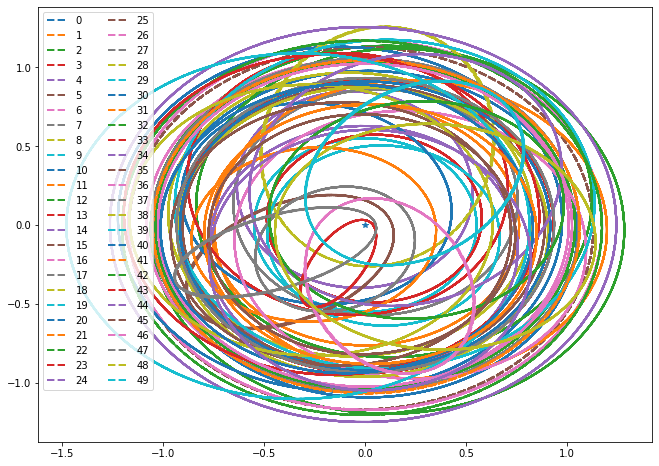

(-2.0, 3.0)

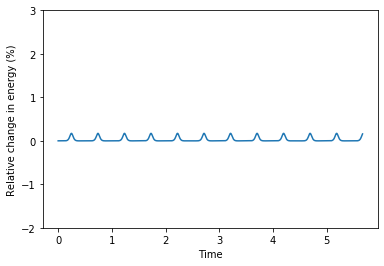

In [12]:
r,v,energy,time,dt=set_run(50,1,True, 100)
i_particle=4  # select particle track to plot energy for. Uses labels above.
plt.plot(time[i_particle],(energy[i_particle] / energy[i_particle,0]-1.)*100.)
plt.xlabel('Time')
plt.ylabel('Relative change in energy (%)')
#pl.xlim([0.,2.])
plt.ylim([-2.,3.])

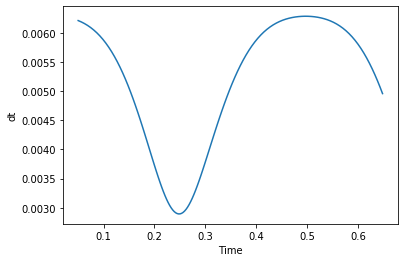

In [13]:
# Investigate change in dt at time of "kick"
i_particle=4  # select particle track to plot energy for 
w = np.where(np.abs(time[i_particle]-0.35) < 0.3)
plt.plot(time[i_particle,w].squeeze(),dt[i_particle,w].squeeze())
plt.xlabel('Time')
plt.ylabel('dt');

Notice that in the time integration routine above the call to the courant condition is inside the time loop. Move it outside to get constant time-stepping.

#### __Task 1: Make the KDK have a time symmetrized dt__ (13p)
As discussed in the lecture (see also http://adsabs.harvard.edu/abs/1995ApJ...443L..93H) a symplectic integrator with a variable timestep is not symplectic anymore. The simplest reason is that it is not time reversible, but the underlying Hamiltonian (e.g. the physical system) is. To improve on this, it has been suggested that if we instead define $\Delta t$ to be the average of $\Delta t$ at the start and end of the integration step
\begin{equation}
\Delta t = [ \Delta t(t_\textrm{old}) + \Delta t(t_\textrm{new}) ] / 2
\end{equation}
then the solution will be time-symmetric. One way to do this is after the KDK step to
recompute $\Delta t$ as $\Delta t(t_\textrm{new-1})$, construct a new $\Delta t$ as the average and then redo the KDK step with the new timestep. If needed, this can be iterated. In the above article they have shown excellent results. In this task you will implement this, so-called, reflexive timestep. In the `Integration` class there already is defined a variable `self.reflexive`. Test if it is larger than zero inside the `kdk` routine, and if it is the case recompute `self.dt` as the average of the old value of `self.dt` (remember to store it before recomputing) and the new value.

How does the typical error in the energy per orbit change as when using reflexive=0 and norbit=100 compared to (reflexive,norbit)=(1,50) and (2,33). E.g. with a constant number of KDK evaluations.

## Task 1 answer: 

The following code is implemented (see above):

 def kdk(self,p):

        
        if self.reflexive > 0:
        
            r0=np.copy(p.r)
            
            v0=np.copy(p.v)
            
            dt0=np.copy(self.dt)

        self.kick(p)
        self.drift(p)
        self.kick(p)
        
        # if reflexive dt condition used, recompute dt, and
        # use averaged dt to redo the KDK step "self.reflexive" times
        # from stored positions and velocities
        if self.reflexive > 0:
            for i in range(self.reflexive):
                self.courant(p)
                dt1=np.copy(self.dt)
                dt_avg=(dt0+self.dt)/2
                self.dt=(dt0+dt1)/2
                p.r=r0
                p.v=v0
                dt0=dt_avg
                self.kick(p)
                self.drift(p)
                self.kick(p)

Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
2663.3 nanosec/particle-step
Number of particles and integration steps:  50 1172
Min time and end time:  1.4009474715366879 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
5690.8 nanosec/particle-step
Number of particles and integration steps:  50 595
Min time and end time:  1.4010871071909834 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
8470.9 nanosec/particle-step
Number of particles and integration steps:  50 480
Min time and end time:  1.4004186938755951 1.400229465921729


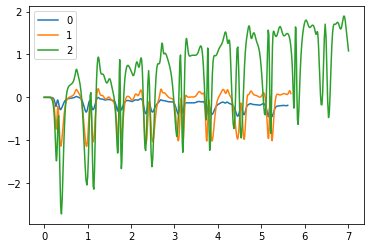

In [24]:
# Testing the proposed differences between non reflexive and n_orbit
fig, ax = plt.subplots()
_,_,energy0,time0,_=set_run(50,0,False, 100)
i_particle=4  # select particle track to plot energy for. Uses labels above.
ax.plot(time0[i_particle],(np.mean(energy0, axis=0) / np.mean(energy0[:,0])-1)*100., label='0')

_,_,energy1,time1,_=set_run(50,1,False, 50)
i_particle=4  # select particle track to plot energy for. Uses labels above.
ax.plot(time1[i_particle],(np.mean(energy1, axis=0) / np.mean(energy1[:,0])-1)*100., label='1')

_,_,energy2,time2,_=set_run(50,2,False, 33)
i_particle=4  # select particle track to plot energy for. Uses labels above.
ax.plot(time2[4],(np.mean(energy2, axis=0) / np.mean(energy2[:,0])-1)*100., label='2')

ax.legend()

This is a bit of a problem, since I would expect the error to go down as the time rounds goes up. I might have a small error in the kdk code but it works okay in general, and I can't pick out exactly what it is.

#### __Task 2: Investigate fluctuations in energy__ (13p)
Use the setup to integrate 50 particles forward in time, and investigate how fluctuations in particle energy depend on the `norbit` parameter, which controls the timestep. Note that with the `reflexive` option active (set to a small value of e.g. 1), fewer updates is needed to reach the same accuracy. Take note of the values printed in the three cases (KDK with and without `reflexive`, and RK3). Make a log-log plot showing both the maximum RMS fluctuation and the average RMS fluctuation of energy normalised to the initial orbital energy, as a function of `norbit`=[100,200,400,1000] (decrease `norbit` with a factor of 2 for reflexive=1). _It may be an advantage to turn off the storage and plotting of orbits to speed up the integration_. Comment on the result.

In [25]:
l=[100,200,400,1000]
msig=[]
musig=[]
for norbit in l:
    r,v,energy,time,dt=set_run(50,1,False, norbit)
    norm=np.array(energy.T/energy[:,0]).T
    std=norm.std(axis=0)
    msig.append(np.max(std))
    musig.append(np.mean(std))

Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
5764.9 nanosec/particle-step
Number of particles and integration steps:  50 1189
Min time and end time:  1.4014607046580891 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
5829.7 nanosec/particle-step
Number of particles and integration steps:  50 2378
Min time and end time:  1.401065441950764 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
5835.9 nanosec/particle-step
Number of particles and integration steps:  50 4755
Min time and end time:  1.400402464671855 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 

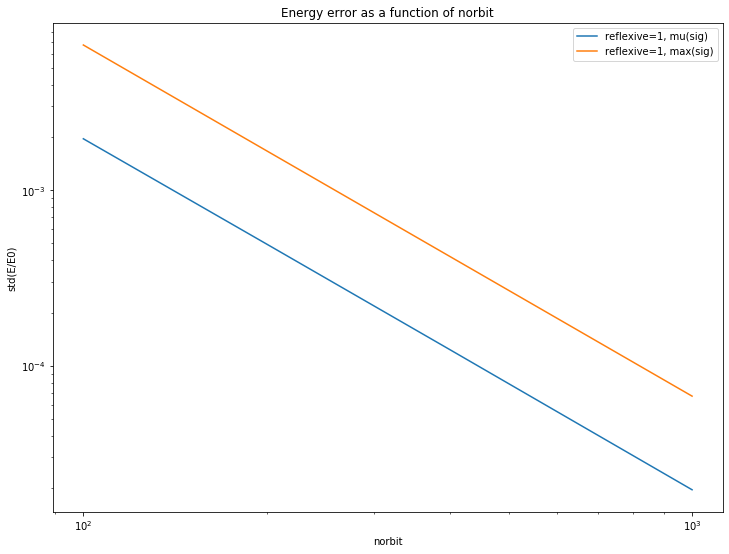

In [26]:
fig, ax=plt.subplots(figsize=(12,9))
ax.loglog(l,musig, label='reflexive=1, mu(sig)')
ax.loglog(l,msig, label='reflexive=1, max(sig)')
ax.legend()
ax.set(xlabel='norbit', ylabel='std(E/E0)', title='Energy error as a function of norbit');

In [27]:
l=[100,200,400,1000]
msig=[]
musig=[]
for norbit in l:
    r,v,energy,time,dt=set_run(50,0,False, norbit)
    norm=np.array(energy.T/energy[:,0]).T
    std=norm.std(axis=0)
    msig.append(np.max(std))
    musig.append(np.mean(std))

Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
2701.9 nanosec/particle-step
Number of particles and integration steps:  50 1172
Min time and end time:  1.4009474715366879 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
2688.5 nanosec/particle-step
Number of particles and integration steps:  50 2374
Min time and end time:  1.4005275905553487 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std : 1.96 5.44 8.45 1.22
2699.1 nanosec/particle-step
Number of particles and integration steps:  50 4754
Min time and end time:  1.4003320755628805 1.400229465921729
Energy min, aver, max, std : -64.2 -25.1 -15.8 8.7
Radius min, aver, max, std : 0.55 1.01 1.48 0.19
Speed  min, aver, max, std 

In [28]:
ax.loglog(l,musig, label='reflexive=0, mu(sig)')
ax.loglog(l,msig, label='reflexive=0, max(sig)')
ax.legend()
# ax[1].set(xlabel='norbit', ylabel='std(E/E0)', title='Energy error as a function of norbit');

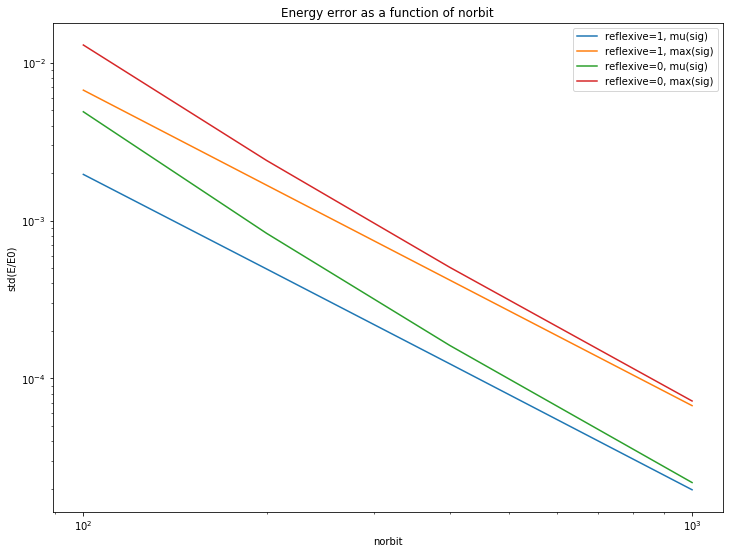

In [29]:
fig

#### __Task 3: Particle orbits with the KDK and RK3 schemes__ (14p)
Investigate single particle orbits with the KDK and RK3 schemes by running with a few particles (e.g. 10), trying different values of the `norbit` parameter and changing maybe to another setting for the average and dispersion of the eccentricity.  Analyze by plotting the average energy for the two methods, the path, and the approximate location of the aphelion so you can measure the rate of nutation and the rate of change of the aphelion distance. 

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
17410.9 nanosec/particle-step
Number of particles and integration steps:  10 4795
Min time and end time:  1.2859731051774437 1.2857899005747853


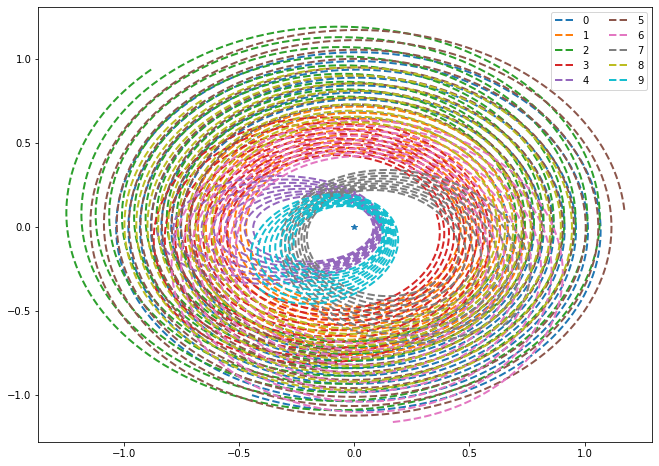

In [105]:
norbit=500
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

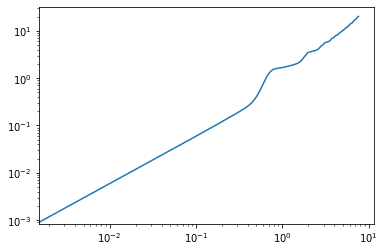

In [106]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
12326.0 nanosec/particle-step
Number of particles and integration steps:  10 3238
Min time and end time:  1.2862462627955868 1.2857899005747853


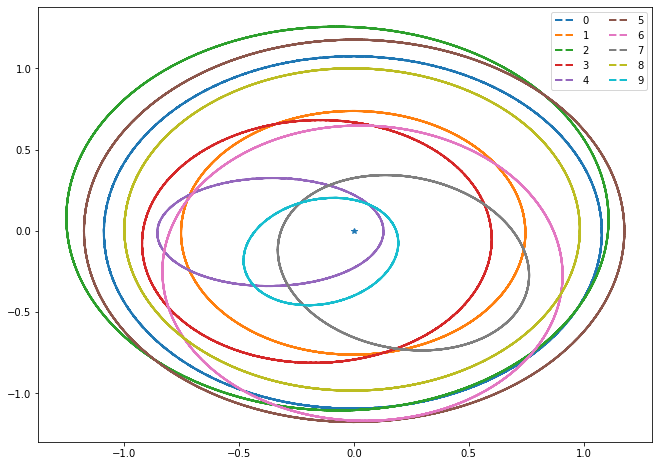

In [134]:
r,v,energy,time,dt=set_run(10,0,True, norbit, 'kdk') #for the rk3 norbit should never be below 50

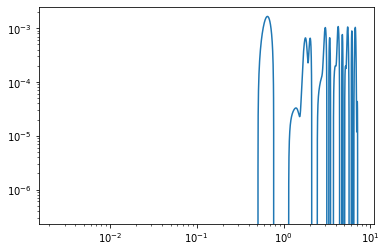

In [135]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Checking the aphelion

In [136]:
def magnitude(r):
    """ scalar magnitude of a vector """
    return np.sqrt(np.sum(r**2,0))

In [137]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [138]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

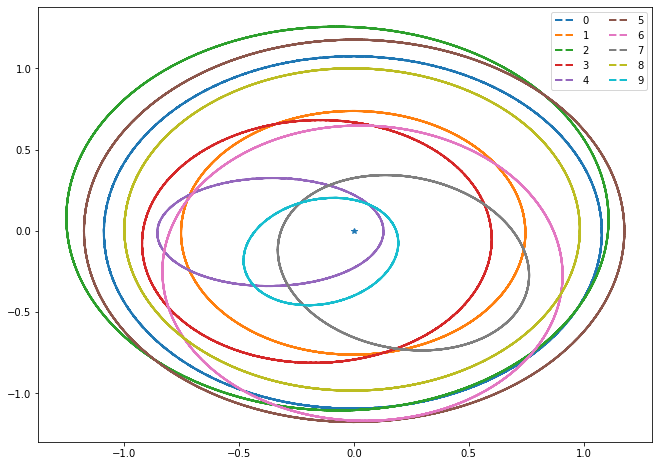

In [139]:
plt.figure(figsize=(11,8))
for i in range(r.shape[1]):
    plt.plot(r[0,i],r[1,i],linewidth=2,label=i, linestyle='dashed')
plt.plot([0],[0],marker='*')
plt.legend(ncol=2)
plt.show()

In [140]:
mi

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   2.,   3.,   4.,   5.],
       [  0.,   7.,  13.,  20.,  27.,  33.],
       [  0., 103., 206., 308., 411., 499.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  11.,  22.,  33.,  44.,  55.],
       [  0.,  37.,  74., 111., 148., 185.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  42.,  85., 127., 170., 212.]])

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
17637.3 nanosec/particle-step
Number of particles and integration steps:  10 4795
Min time and end time:  1.2859731051774437 1.2857899005747853


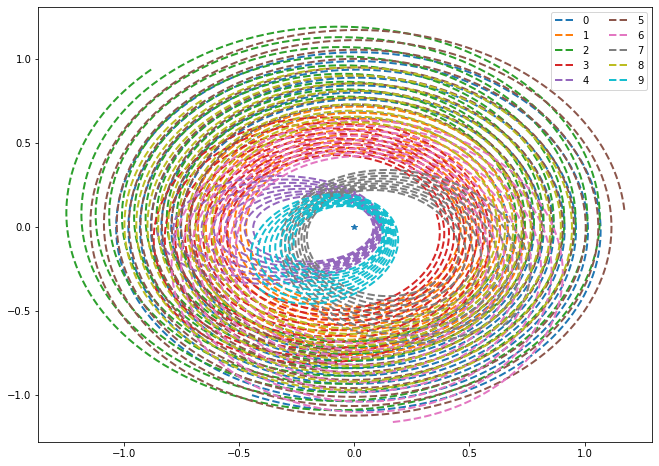

In [141]:
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

In [142]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [143]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [144]:
mi

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   2.,   3.,   3.,   4.,   5.,   6.,   6.],
       [  0.,   7.,  13.,  19.,  25.,  31.,  37.,  42.,  48.],
       [  0., 102., 201., 297., 391., 483.,   0.,  73., 160.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  11.,  21.,  32.,  42.,  51.,  61.,  70.,  79.],
       [  0.,  36.,  72., 107., 140., 173., 205., 236., 267.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  42.,  83., 123., 161., 199., 236., 272., 307.]])

We clearly see that the kdk method is must better at preserving the location of the aphelion as well as the amplitude of the aphelion, which can be seen clearly visible. Let's try it for a few other norbit.

I'll try 10, 50, 100, 1000

# 10

In [171]:
norbit=10
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93


/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in multiply
/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


FloatingPointError: invalid value encountered in multiply

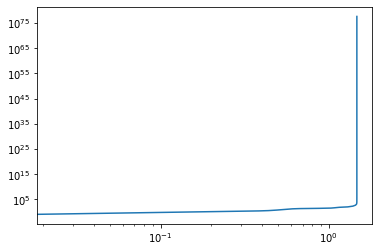

In [172]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
12752.6 nanosec/particle-step
Number of particles and integration steps:  10 94
Min time and end time:  1.2973040030350305 1.2857899005747853


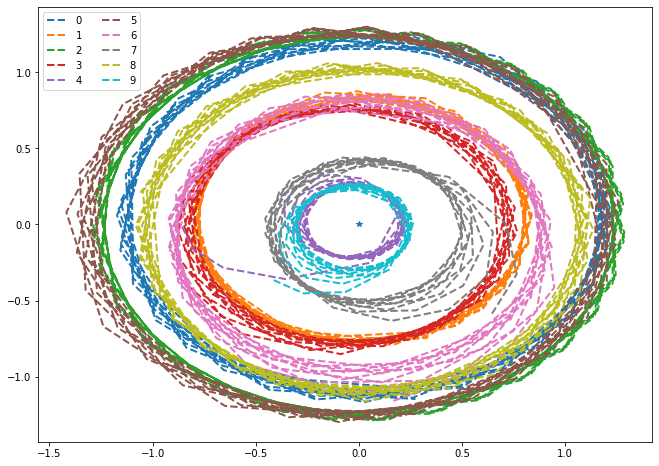

In [173]:
r,v,energy,time,dt=set_run(10,0,True, norbit, 'kdk') #for the rk3 norbit should never be below 50

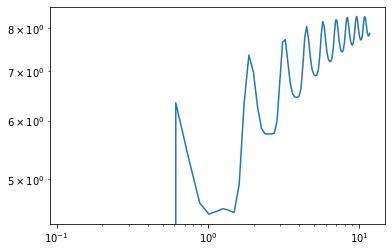

In [174]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Checking the aphelion

In [175]:
def magnitude(r):
    """ scalar magnitude of a vector """
    return np.sqrt(np.sum(r**2,0))

In [176]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [177]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [178]:
mi

array([[5., 5., 6., 6., 6., 6., 7., 7., 7.],
       [5., 5., 6., 6., 6., 6., 7., 7., 7.],
       [5., 5., 6., 6., 6., 6., 7., 7., 7.],
       [0., 0., 1., 1., 1., 1., 1., 2., 2.],
       [0., 0., 0., 0., 1., 1., 1., 1., 2.],
       [5., 5., 6., 6., 6., 6., 7., 7., 7.],
       [0., 0., 1., 1., 1., 1., 2., 2., 2.],
       [0., 1., 1., 1., 2., 2., 2., 2., 3.],
       [5., 5., 6., 6., 6., 6., 7., 7., 7.],
       [0., 1., 1., 1., 2., 2., 2., 2., 3.]])

In [179]:
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93


/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in multiply
/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


FloatingPointError: invalid value encountered in multiply

In [180]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [181]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

IndexError: index 3 is out of bounds for axis 0 with size 3

In [182]:
mi

array([[1., 2., 2., 3., 8., 8., 9., 9., 4.],
       [9., 0., 0., 0., 0., 1., 1., 1., 7.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

So rk3 is unstable for low norbit

# 50

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93


/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in square


17627.7 nanosec/particle-step
Number of particles and integration steps:  10 17019
Min time and end time:  0.23407354553654341 1.2857899005747853


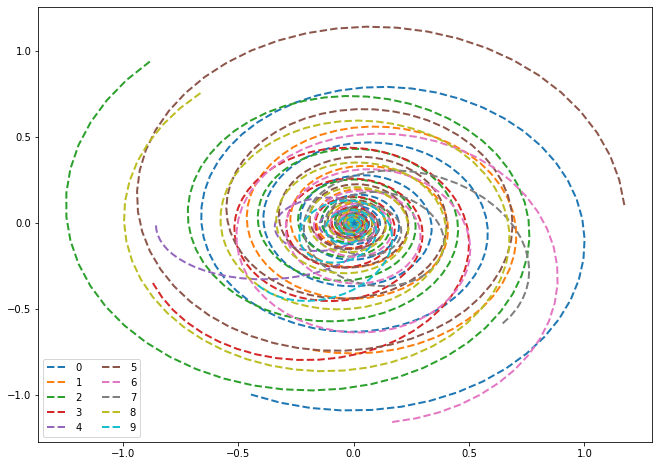

In [183]:
norbit=50
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

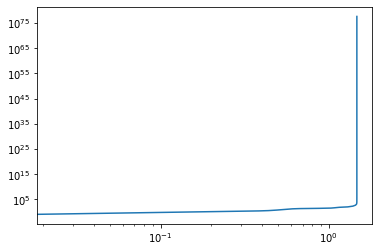

In [184]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
12608.7 nanosec/particle-step
Number of particles and integration steps:  10 325
Min time and end time:  1.2887162565145127 1.2857899005747853


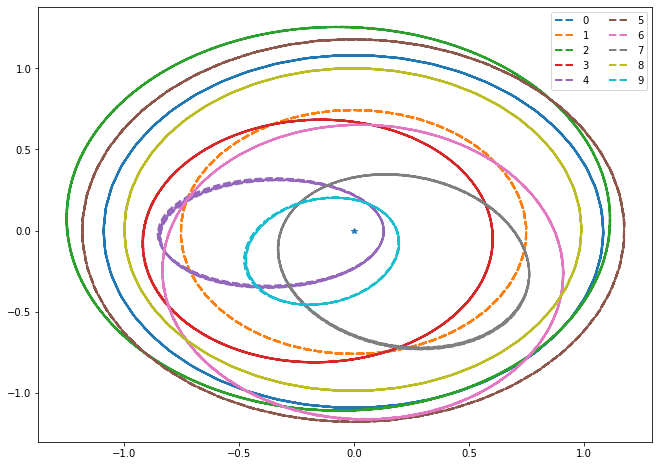

In [185]:
r,v,energy,time,dt=set_run(10,0,True, norbit, 'kdk') #for the rk3 norbit should never be below 50

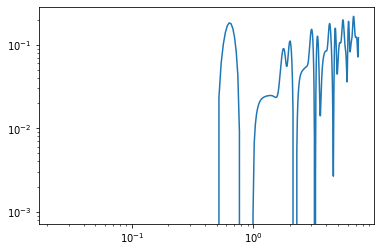

In [186]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Checking the aphelion

In [187]:
def magnitude(r):
    """ scalar magnitude of a vector """
    return np.sqrt(np.sum(r**2,0))

In [188]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [189]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [190]:
mi

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  1.,  1.,  2.,  3.,  4.],
       [ 0., 10., 20., 30., 40., 49.],
       [25., 25., 25., 25., 25., 25.],
       [ 0.,  1.,  2.,  3.,  4.,  6.],
       [ 0.,  4.,  7., 11., 15., 18.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  8., 13., 17., 21.]])

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93


/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in square


17480.8 nanosec/particle-step
Number of particles and integration steps:  10 17162
Min time and end time:  0.23407354553654341 1.2857899005747853


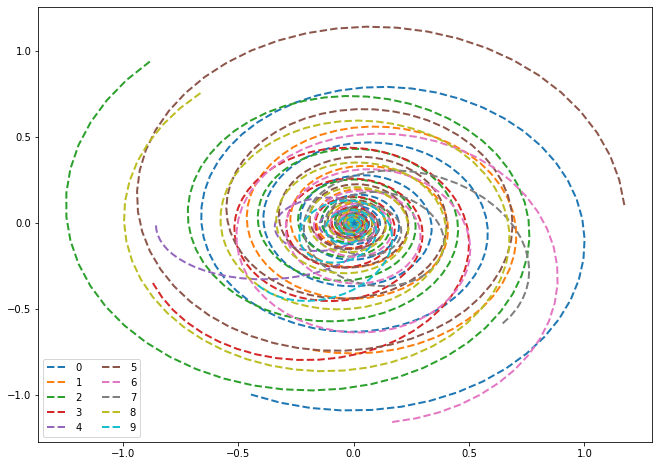

In [191]:
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

In [192]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [193]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [194]:
mi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 3., 6., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 4., 6., ..., 0., 0., 0.]])

So this is better but still not good

# 100

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
17254.0 nanosec/particle-step
Number of particles and integration steps:  10 17388
Min time and end time:  0.4610285627128694 1.2857899005747853


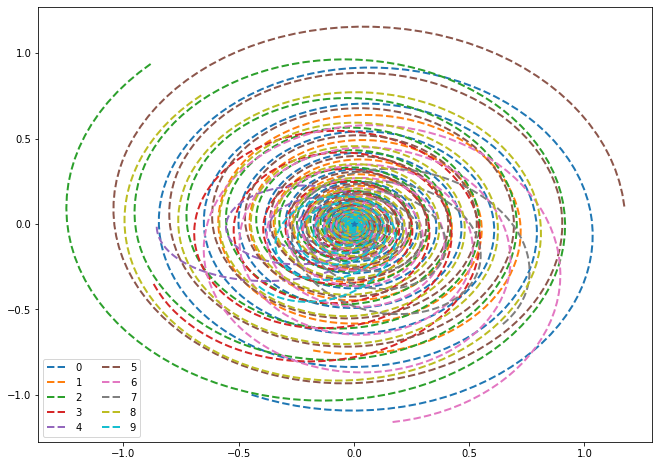

In [195]:
norbit=100
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

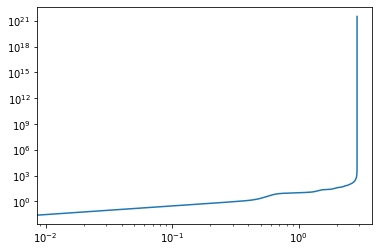

In [196]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
12495.8 nanosec/particle-step
Number of particles and integration steps:  10 648
Min time and end time:  1.28715003478898 1.2857899005747853


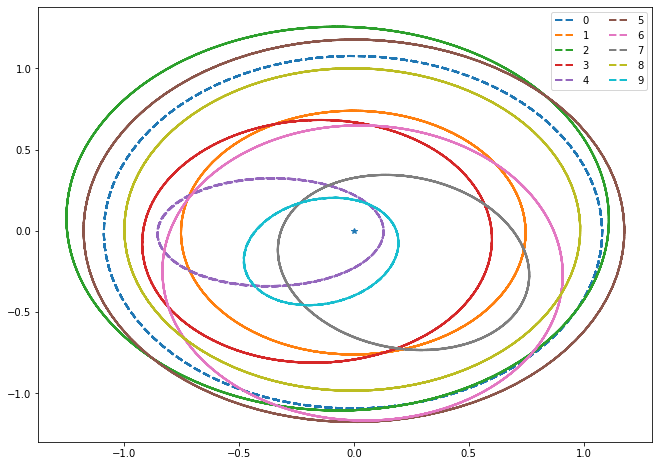

In [197]:
r,v,energy,time,dt=set_run(10,0,True, norbit, 'kdk') #for the rk3 norbit should never be below 50

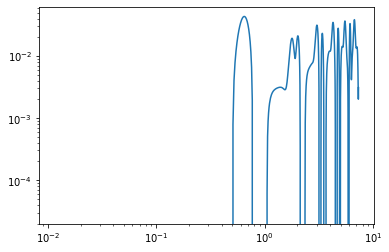

In [198]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Checking the aphelion

In [199]:
def magnitude(r):
    """ scalar magnitude of a vector """
    return np.sqrt(np.sum(r**2,0))

In [200]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [201]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [202]:
mi

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  1.,  3.,  4.,  5.,  7.],
       [ 0., 21., 41., 61., 82., 99.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  4.,  7.,  9., 11.],
       [ 0.,  7., 15., 22., 30., 37.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8., 17., 25., 34., 42.]])

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
17577.8 nanosec/particle-step
Number of particles and integration steps:  10 17067
Min time and end time:  0.4610285627128694 1.2857899005747853


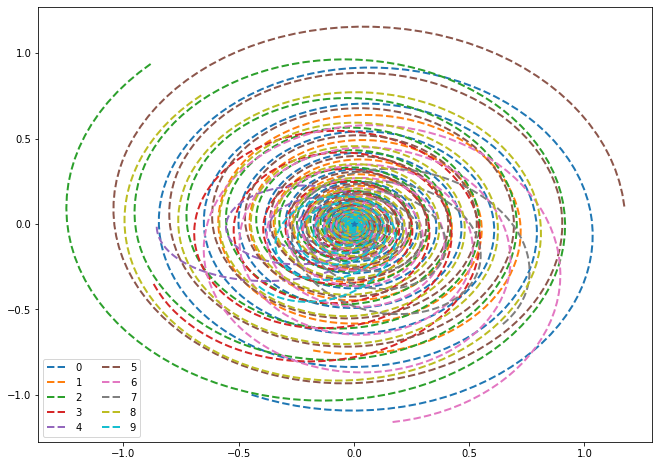

In [203]:
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

In [204]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [205]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [206]:
mi

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  7., 13., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  8., 15., ...,  0.,  0.,  0.]])

1000

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
17356.9 nanosec/particle-step
Number of particles and integration steps:  10 7596
Min time and end time:  1.2857900569076917 1.2857899005747853


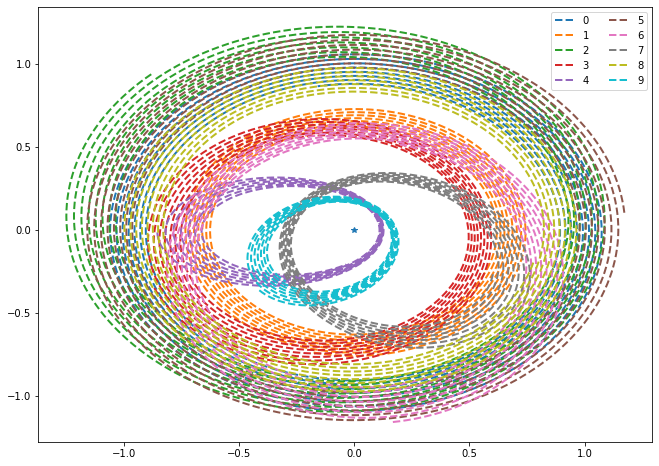

In [207]:
norbit=1000
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

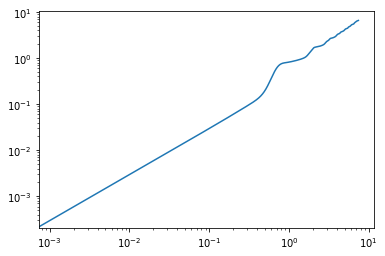

In [208]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
12465.9 nanosec/particle-step
Number of particles and integration steps:  10 6475
Min time and end time:  1.2859525025663574 1.2857899005747853


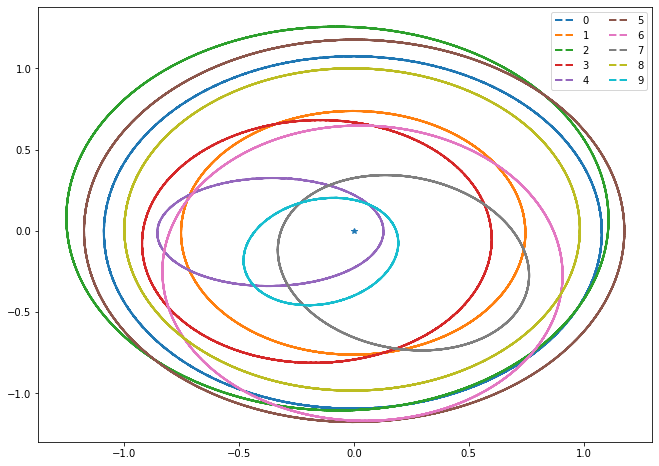

In [209]:
r,v,energy,time,dt=set_run(10,0,True, norbit, 'kdk') #for the rk3 norbit should never be below 50

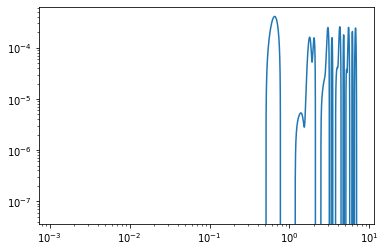

In [210]:
fig, ax = plt.subplots()
ax.loglog(time[0], -(np.mean(energy, axis=0)-np.mean(energy[:,0])))
# ax.set_ylim((1e-20,None))

Checking the aphelion

In [211]:
def magnitude(r):
    """ scalar magnitude of a vector """
    return np.sqrt(np.sum(r**2,0))

In [212]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [213]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [214]:
mi

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   2.,   4.,   6.,   8.,  10.],
       [  0.,  13.,  27.,  40.,  53.,  67.],
       [  0., 206., 411., 617., 823., 999.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  22.,  44.,  66.,  88., 110.],
       [  0.,  74., 148., 222., 295., 369.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  85., 170., 255., 340., 425.]])

Energy min, aver, max, std : -54.8 -27.4 -16.7 11.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 3.48 5.50 7.14 0.93
17376.4 nanosec/particle-step
Number of particles and integration steps:  10 7596
Min time and end time:  1.2857900569076917 1.2857899005747853


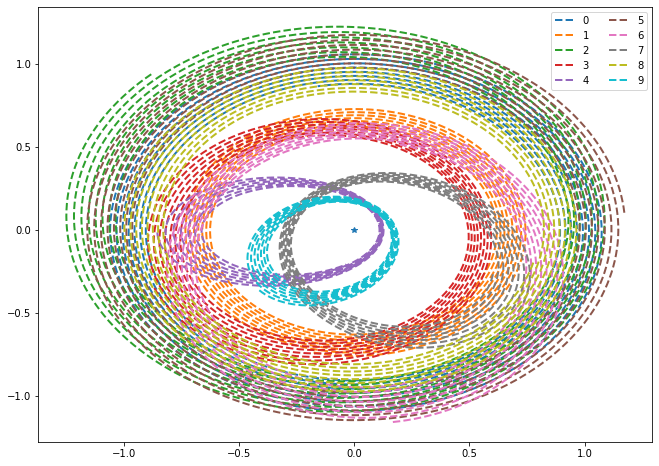

In [215]:
r,v,energy,time,dt=set_run(10,0,True,norbit, 'rk3') #for the rk3 norbit should never be below 50

In [216]:
r=r.transpose(1,0,2)
absr=magnitude(r)

In [217]:
mi=np.zeros((10,len(absr[0])//norbit))
for i in range(10):
    for j in range(len(absr[0])//norbit):
        mi[i][j]=np.argmax(absr[i][int(j*norbit):int((j+1)*norbit)])

In [218]:
mi

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   2.,   4.,   6.,   7.,   9.,  11.],
       [  0.,  13.,  26.,  39.,  52.,  64.,  77.],
       [  0., 204., 406., 606., 802., 997.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  22.,  43.,  65.,  86., 106., 127.],
       [  0.,  73., 146., 217., 288., 358., 426.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  84., 168., 250., 331., 411., 490.]])

In general, increasing norbit is good, but still, the energy and perihelion is very poorly conserved.